# Crystal Structure Generation Priors

This notebook demonstrates how the constants and distributions that control structure generation were determined. There are two separate goals:

- Generating parameters that are strictly impossible should be avoided. For example, trying to generate structures with a lattice that is too small wastes a lot of time checking distances that won't work out.
- The distribution of generations should match the distribution of crystals as much as is feasible. For example, if an orthorhombic lattice is being generated, side ratios of 1:2:100 should be extremely unlikely.

I use the MP20 dataset to ground these choices in real data. 

In [1]:
import seaborn as sns
import numpy as np
import pandas as pd
import rho_plus as rp
import torch
import pyro.distributions as dist
from baysic.utils import load_mp20, quick_view
from pymatgen.analysis.molecule_structure_comparator import CovalentRadius
import matplotlib.pyplot as plt
from pymatgen.analysis.molecule_structure_comparator import CovalentRadius


IS_DARK = False
theme, cs = rp.mpl_setup(IS_DARK)
rp.plotly_setup(IS_DARK)

In [2]:
df = load_mp20('train')
df.head()

,Unnamed: 0,material_id,formation_energy_per_atom,band_gap,pretty_formula,e_above_hull,struct,comp,sg_number,sg_symbol,conv,hall,wyckoffs,crystallographic_orbits,equivalent_atoms,std_mapping_to_primitive,lattice,num_atoms,sg
0,37228,mp-1221227,-1.637460,0.2133,Na3MnCoNiO6,0.043001,"[[-2.13163694 -1.97863317 -0.78933557] Na, [-1...","(Na, Mn, Co, Ni, O)",8,Cm,"[[11.33211764 1.514642 5.35627895] Na, [1....",C -2y,"[a, a, a, a, a, a, a, a, a, a, a, a]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2...",0.603093 -2.968643 0.000000\n0.000000 0.000000...,12,((Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]...
1,19480,mp-974729,-0.314759,0.0000,Nd(Al2Cu)4,0.000000,"[[0. 0. 0.] Nd, [7.81740995 6.73412703 1.55353...","(Nd, Al, Cu)",139,I4/mmm,"[[0. 0. 0.] Nd, [4.450648 4.450648 2.599559] N...",-I 4 2,"[a, j, j, i, i, i, i, j, j, f, f, f, f]","[0, 1, 1, 3, 3, 3, 3, 1, 1, 9, 9, 9, 9]","[0, 1, 1, 3, 3, 3, 3, 1, 1, 9, 9, 9, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 0, ...",1.713765 4.489418 -1.984682\n1.713765 4.489418...,13,((Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]...
2,29624,mp-1185360,-0.193761,0.0000,LiMnIr2,0.018075,[[5.00000041e-11 5.10035615e+00 0.00000000e+00...,"(Li, Mn, Ir)",225,Fm-3m,"[[0. 2.944692 0. ] Li, [0. 0....",-F 4 2 3,"[b, a, c, c]","[0, 1, 2, 2]","[0, 1, 2, 2]","[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]",1.202165 3.400237 2.082212\n1.202165 3.400237 ...,4,((Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]...
3,38633,mp-1188861,-0.584694,3.8556,LiCSN,0.048847,"[[ 0.96469575 2.34470985 11.12401327] Li, [0....","(Li, C, S, N)",62,Pnma,"[[11.12401327 0.96469575 2.34470985] Li, [4....",-P 2ac 2n,"[c, c, c, c, c, c, c, c, c, c, c, c, c, c, c, c]","[0, 0, 0, 0, 4, 4, 4, 4, 8, 8, 8, 8, 12, 12, 1...","[0, 0, 0, 0, 4, 4, 4, 4, 8, 8, 8, 8, 12, 12, 1...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3.858783 0.000000 0.000000\n-0.000000 5.345396...,16,((Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]...
4,10889,mp-677272,-2.474759,0.4707,La2EuS4,0.000000,"[[ 0.03187948 -4.65810216 -3.8370089 ] La, [ 2...","(La, Eu, S)",122,I-42d,"[[6.584643 7.65405048 3.26744475] La, [7.654...",I -4 2bw,"[d, d, d, d, a, a, e, e, e, e, e, e, e, e]","[0, 0, 0, 0, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6]","[0, 0, 0, 0, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3.552553 -6.184474 -2.579065\n-3.606854 6.184...,14,((Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]...


In [3]:
from baysic.lattice import atomic_volume
df['lattice_type'] = df['sg'].apply(lambda sg: sg.lattice_type)
df['lattice_volume'] = df['conv'].apply(lambda c: c.lattice.volume)
df['atomic_volume'] = df['conv'].apply(lambda c: atomic_volume(c.composition))
df['volume_ratio'] = df.eval('lattice_volume / atomic_volume')
df.loc[df['volume_ratio'] >= 20, 'volume_ratio'] = np.nan
df.head()

,Unnamed: 0,material_id,formation_energy_per_atom,band_gap,pretty_formula,e_above_hull,struct,comp,sg_number,sg_symbol,...,crystallographic_orbits,equivalent_atoms,std_mapping_to_primitive,lattice,num_atoms,sg,lattice_type,lattice_volume,atomic_volume,volume_ratio
0,37228,mp-1221227,-1.637460,0.2133,Na3MnCoNiO6,0.043001,"[[-2.13163694 -1.97863317 -0.78933557] Na, [-1...","(Na, Mn, Co, Ni, O)",8,Cm,...,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 0, 1, 2...",0.603093 -2.968643 0.000000\n0.000000 0.000000...,12,((Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]...,monoclinic,254.630666,195.679840,1.301262
1,19480,mp-974729,-0.314759,0.0000,Nd(Al2Cu)4,0.000000,"[[0. 0. 0.] Nd, [7.81740995 6.73412703 1.55353...","(Nd, Al, Cu)",139,I4/mmm,...,"[0, 1, 1, 3, 3, 3, 3, 1, 1, 9, 9, 9, 9]","[0, 1, 1, 3, 3, 3, 3, 1, 1, 9, 9, 9, 9]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 0, ...",1.713765 4.489418 -1.984682\n1.713765 4.489418...,13,((Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]...,tetragonal,411.942083,263.834839,1.561363
2,29624,mp-1185360,-0.193761,0.0000,LiMnIr2,0.018075,[[5.00000041e-11 5.10035615e+00 0.00000000e+00...,"(Li, Mn, Ir)",225,Fm-3m,...,"[0, 1, 2, 2]","[0, 1, 2, 2]","[0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3, 0, 1, 2, 3]",1.202165 3.400237 2.082212\n1.202165 3.400237 ...,4,((Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]...,cubic,204.272364,185.623611,1.100465
3,38633,mp-1188861,-0.584694,3.8556,LiCSN,0.048847,"[[ 0.96469575 2.34470985 11.12401327] Li, [0....","(Li, C, S, N)",62,Pnma,...,"[0, 0, 0, 0, 4, 4, 4, 4, 8, 8, 8, 8, 12, 12, 1...","[0, 0, 0, 0, 4, 4, 4, 4, 8, 8, 8, 8, 12, 12, 1...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",3.858783 0.000000 0.000000\n-0.000000 5.345396...,16,((Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]...,orthorhombic,254.597522,67.049210,3.797174
4,10889,mp-677272,-2.474759,0.4707,La2EuS4,0.000000,"[[ 0.03187948 -4.65810216 -3.8370089 ] La, [ 2...","(La, Eu, S)",122,I-42d,...,"[0, 0, 0, 0, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6]","[0, 0, 0, 0, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",-3.552553 -6.184474 -2.579065\n-3.606854 6.184...,14,((Rot:\n[[1. 0. 0.]\n [0. 1. 0.]\n [0. 0. 1.]]...,tetragonal,671.612740,504.872864,1.330261


## Lattice Volume and Atomic Distance

We can take the volumes of each atom (using covalent radii), sum them, and consider the lattice's volume in relation. The result, excluding a few outliers (2D materials with bizarrely long separations between planes and H/He crystals), has a very nice smooth distribution.

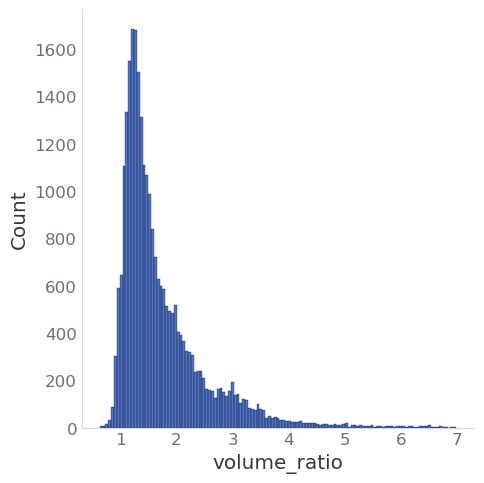

In [4]:
sns.displot(df.query('volume_ratio <= 7'), x='volume_ratio')

The minimum atomic distance in a structure as a ratio of the covalent radius also follows a nice distribution:

<Axes: xlabel='min_ratio', ylabel='Count'>

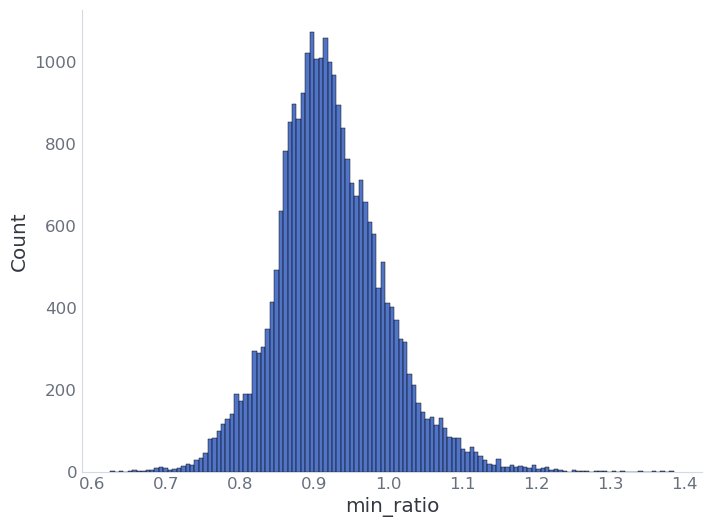

In [5]:
from baysic.utils import upper_tri
dist_ratios = []
structs = []
inds = []
min_ratios = []
min_specs = []
for i in df.index:
    s = df.loc[i, 'conv']
    dists = upper_tri(s.distance_matrix)
    rads = np.array([CovalentRadius.radius[spec.symbol] for spec in s.species])
    specs = np.array([spec.symbol for spec in s.species])
    rads = upper_tri(rads.reshape(-1, 1) + rads.reshape(1, -1))
    specs = upper_tri(np.char.add(np.char.add(specs.reshape(-1, 1), '-'), specs.reshape(1, -1)))
    ratios = list(dists / rads)
    inds.extend([i] * len(ratios))
    dist_ratios.extend(ratios)
    min_ratios.append(min(ratios) if ratios else np.nan)
    min_specs.append(specs[np.argmin(ratios)] if ratios else np.nan)

dist_ratios = np.array(dist_ratios)
df['min_ratio'] = min_ratios
df['min_specs'] = min_specs
sns.histplot(df.query('min_ratio < 1.5'), x='min_ratio')

The minima are especially important here, because that's the primary constraint that drives structure generation. We can see that this only happens for certain elements:

In [6]:
subs = df[['material_id', 'pretty_formula', 'volume_ratio', 'min_ratio', 'min_specs']]
display(subs.sort_values('min_ratio').head(5))
display(subs.sort_values('volume_ratio').head(5))

,material_id,pretty_formula,volume_ratio,min_ratio,min_specs
2421,mp-1179962,Pu,0.692142,0.624792,Pu-Pu
15886,mp-1217516,UNiSn,1.142008,0.628247,U-U
9311,mp-1223022,LaU3Al8,1.236775,0.639155,U-U
11031,mp-1178958,U,0.652907,0.652485,U-U
14440,mp-1216984,U12FeNi,0.676099,0.656536,U-U


,material_id,pretty_formula,volume_ratio,min_ratio,min_specs
20459,mp-44,U,0.633682,0.691337,U-U
11031,mp-1178958,U,0.652907,0.652485,U-U
2029,mp-568195,U6Mn,0.668466,0.670220,U-U
14812,mp-613989,Pu,0.669705,0.658666,Pu-Pu
10676,mp-21108,U6Fe,0.671223,0.664826,U-U


The minimum distance ratio is 0.62, but we can see that this only happens for a few elements. By special-casing four rare elements, we can significantly tighten the threshold for the others.

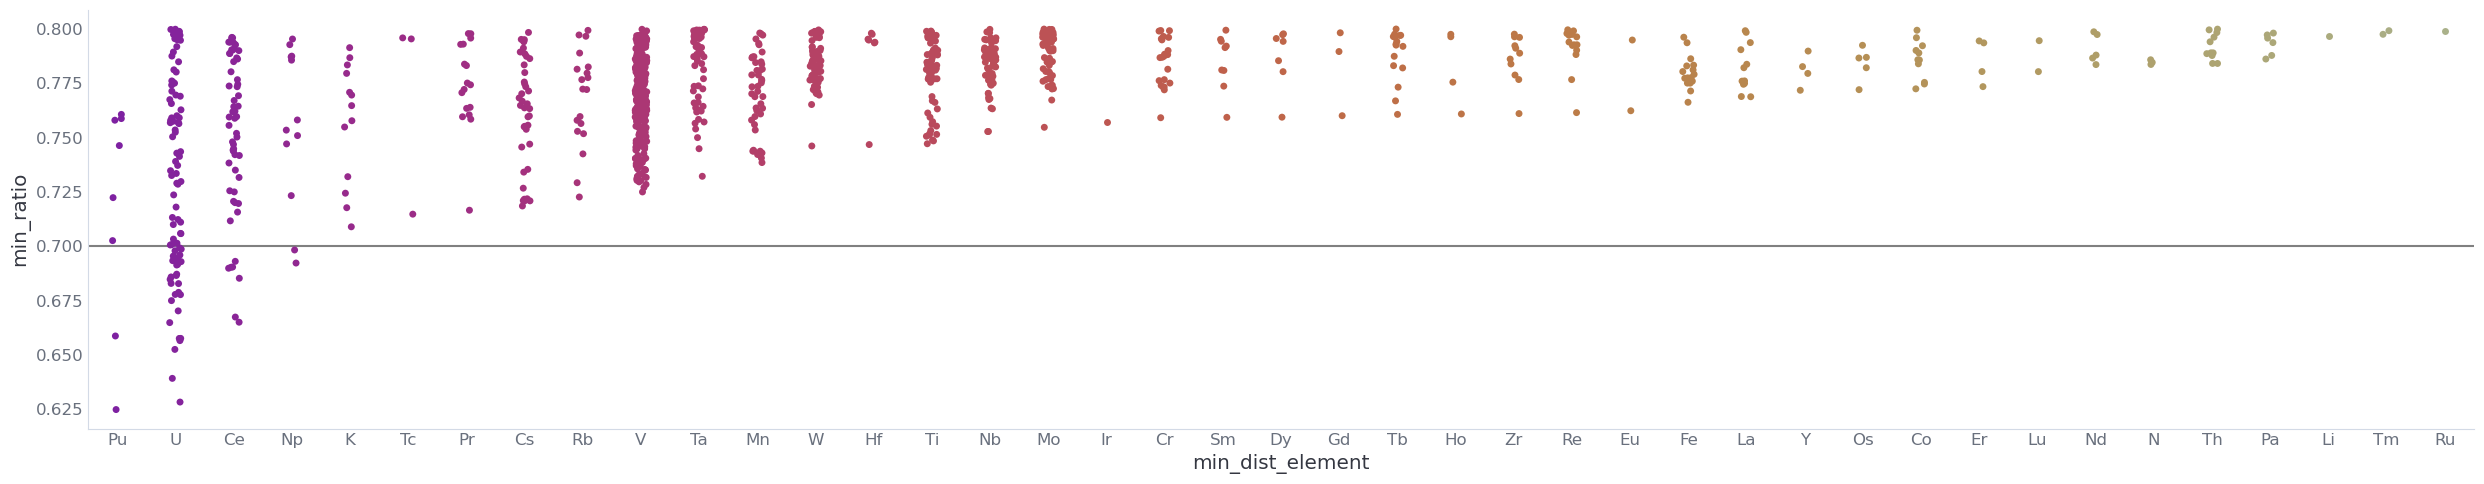

In [7]:
from pymatgen.core import Element

df[['min_spec1', 'min_spec2']] = df['min_specs'].fillna(' - ').str.split('-', expand=True)
df['min_dist_element'] = [max(a, b, key=lambda x: Element(x).number if x != ' ' else 0) for a, b in df[['min_spec1', 'min_spec2']].values]
subs = df.query('min_ratio < 0.8')
order = subs[['min_dist_element', 'min_ratio']].groupby('min_dist_element').min().sort_values('min_ratio').index

sns.catplot(subs, x='min_dist_element', y='min_ratio', order=order, aspect=5, height=5, hue='min_dist_element', palette='rho_solara', hue_order=order, legend=None)
plt.axhline(0.7, c='grey', lw=1.5)

(Pa is added to the above four so the lattice volume can be tighter.)
In 94% of cases, we can up the bounds to 0.7 and 0.77 for the minimum atomic distance and minimum lattice volume. By adding Pa, we can get a much better volume ratio bound as well.

It's fine if one or two structures in something else are below these values: as long as the closest good structure is also a good structure, we can relax it into the correct position afterwards.

In [8]:
df['needs_tight_radii'] = df['comp'].apply(lambda c: any([e.symbol in ['Pu', 'U', 'Ce', 'Np', 'Pa'] for e in c.elements]))

print('{:.2%} of structures need the tighter bound'.format((df['needs_tight_radii']).mean()))
display(df.query('not needs_tight_radii').sort_values('min_ratio').head()[['material_id', 'pretty_formula', 'volume_ratio', 'min_ratio']])
display(df.query('not needs_tight_radii').sort_values('volume_ratio').head()[['material_id', 'pretty_formula', 'volume_ratio', 'min_ratio']])

6.29% of structures need the tighter bound


,material_id,pretty_formula,volume_ratio,min_ratio
9206,mp-1080119,K2PtO6,1.351088,0.708933
1532,mp-28408,KTcCl3,2.226503,0.714756
7832,mp-1105805,Pr5Ga3,1.139843,0.716570
14937,mp-504570,K3FeO3,1.103757,0.717727
18707,mp-504849,Cs2Li2SiO4,0.991389,0.718525


,material_id,pretty_formula,volume_ratio,min_ratio
10434,mp-753799,CsTmO2,0.792489,0.901578
24605,mp-1185970,Mn3Co,0.792896,0.807238
22377,mp-639892,GdMn12,0.794916,0.768890
4080,mp-980811,TmMn12,0.802248,0.765572
1749,mp-31221,ThMn12,0.804185,0.740580


## Lattice Volume Distribution

To fit distributions, we can use the below monstrosity. Don't worry about it: these priors don't have to make mathematical sense, they just have to approximate the true distribution. I use KL-divergence because it's asymmetric in the way we want: it's OK if the prior is a bit too diffuse, but we can't find structures we don't try.

In [9]:
from scipy.stats import gaussian_kde
from scipy.optimize import minimize
from torch.distributions import transform_to

obs = df['volume_ratio'][df['volume_ratio'] < 10]

def caveman_fit(obs, fit_constraint=True, use_folds=True):
    """Fits a distribution to the data. Don't ask how."""
    obs = np.asanyarray(obs)
    obs = obs[~np.isnan(obs)]

    obs_kde = gaussian_kde(obs)
    obs_probs = obs_kde(obs)

    obs_tensor = torch.tensor(obs)
    obs_probs_tensor = torch.tensor(obs_probs)

    can_fold = False
    outside_support = []
    if fit_constraint:
        lo = obs.min()
        hi = obs.max()
        if lo >= 0:
            outside_support.append(-1)
            if hi <= 1:
                outside_support.append(2)
            else:
                can_fold = True

    outside_support = torch.tensor(outside_support).float()

    options = []
    families = []
    wrappers = []
    for dist_name in dir(dist):
        dist_fam = getattr(dist, dist_name)
        if (isinstance(dist_fam, dist.distribution.DistributionMeta) and
            hasattr(dist_fam, 'support') and
            dist_name not in ['Unit', 'VonMises']):
            try:
                if (dist_fam.support.event_dim == 0 and
                dist_fam.support.check(obs_tensor).all()):
                    if (~dist_fam.support.check(outside_support)).all():
                        options.append(dist_name)
                        families.append(dist_fam)
                        wrappers.append(lambda x: x)
                    elif use_folds and can_fold:
                        options.append('Folded' + dist_name)
                        families.append(dist_fam)
                        wrappers.append(dist.FoldedDistribution)


            except (ValueError, AttributeError, NotImplementedError):
                # dependent constraint or family, ignore
                continue

    scores = []
    ends = []
    for name, dist_cls, wrapper in zip(options, families, wrappers):
        start = {}
        for k in dist_cls.arg_constraints:
            start[k] = transform_to(dist_cls.arg_constraints[k])(torch.tensor(0.0)).item()

        # logits and probs conflict: only do probs
        if 'probs' in start and 'logits' in start:
            del start['logits']

        try:
            dist_cls(**start).log_prob(obs_tensor[0])
        except (TypeError, NotImplementedError):
            scores.append(np.inf)
            ends.append({})
            continue

        def kl_div(*args):
            args = np.asanyarray(args).flatten()
            kwargs = {k: transform_to(dist_cls.arg_constraints[k])(torch.tensor(arg))
            for k, arg in zip(start, args)}
            return torch.mean(obs_probs_tensor.log() - wrapper(dist_cls(**kwargs)).log_prob(obs_tensor)).item()

        res = minimize(kl_div, np.array(tuple(start.values())), tol=1e-2)

        end = {}
        for k, arg in zip(start, res.x):
            end[k] = transform_to(dist_cls.arg_constraints[k])(torch.tensor(arg)).item()

        scores.append(res.fun)
        ends.append(end)

    res_df = pd.DataFrame({'family': options, 'kl': scores, 'params': ends, 'i': np.arange(len(ends))}).sort_values('kl')
    best_fam, best_kl, best_end, best_i = res_df.iloc[0]
    print(families[best_i])
    best_dist = wrappers[best_i]((families[best_i])(**best_end))

    xx = np.linspace(np.min(obs), np.max(obs), 1000)
    yy = best_dist.log_prob(torch.tensor(xx)).exp().cpu().numpy()
    sns.kdeplot(x=obs, lw=1, bw_adjust=0.15, cut=0)
    sns.lineplot(x=xx, y=yy, ls='--', lw=1, c=cs[1])
    plt.title(best_fam + '\n' + '\n'.join(f'{k:>20}={v:.3f}' for k, v in best_end.items()), ha='right')
    res_df = pd.concat([res_df[['family', 'kl']].reset_index(drop=True), pd.json_normalize(res_df['params']).reset_index(drop=True), res_df['params'].reset_index(drop=True)],
    axis=1)
    return res_df

We can split into these two cases to get better fits. We can see the lattice volumes are fairly predictable, with a few outliers as I alluded to earlier.

<class 'pyro.distributions.torch.LogNormal'>


,family,kl,loc,scale,asymmetry,concentration,rate,df1,df2,df,softness,params
0,LogNormal,0.001,-0.252,0.72,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'loc': -0.25180443351841947, 'scale': 0.71963..."
1,FoldedAsymmetricLaplace,0.007,0.318,0.25,0.322,NaN,NaN,NaN,NaN,NaN,NaN,"{'loc': 0.3181962251242432, 'scale': 0.2503166..."
2,InverseGamma,0.025,NaN,NaN,NaN,2.13,1.283,NaN,NaN,NaN,NaN,"{'concentration': 2.1301290689246013, 'rate': ..."
3,FisherSnedecor,0.039,NaN,NaN,NaN,NaN,NaN,5.306,16.52,NaN,NaN,"{'df1': 5.306469514730685, 'df2': 16.519719230..."
4,Gamma,0.064,NaN,NaN,NaN,2.00,1.975,NaN,NaN,NaN,NaN,"{'concentration': 2.000442684126884, 'rate': 1..."


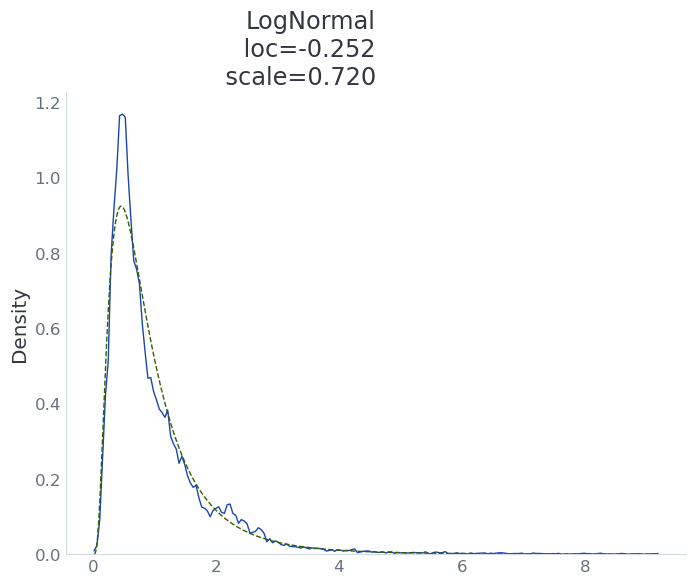

In [10]:
# res_df = caveman_fit(1 / (1 + df['volume_ratio']), fit_constraint=True).round(3)
res_df = caveman_fit(df.query('not needs_tight_radii and volume_ratio <= 10')['volume_ratio'] - 0.77).round(3)
res_df.head()

<class 'pyro.distributions.asymmetriclaplace.AsymmetricLaplace'>


,family,kl,loc,scale,asymmetry,softness,concentration,rate,df1,df2,df,params
0,FoldedAsymmetricLaplace,0.018,0.547,0.211,0.668,NaN,NaN,NaN,NaN,NaN,NaN,"{'loc': 0.5467870985236409, 'scale': 0.2113090..."
1,FoldedSoftAsymmetricLaplace,0.018,0.548,0.211,0.672,0.03,NaN,NaN,NaN,NaN,NaN,"{'loc': 0.5484418914179624, 'scale': 0.2111059..."
2,FoldedSkewLogistic,0.032,-0.450,0.088,0.284,NaN,NaN,NaN,NaN,NaN,NaN,"{'loc': -0.4502438362883628, 'scale': 0.087688..."
3,LogNormal,0.083,-0.442,0.490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'loc': -0.44186464265836306, 'scale': 0.49018..."
4,Gamma,0.096,NaN,NaN,NaN,NaN,4.35,6.004,NaN,NaN,NaN,"{'concentration': 4.349974774934092, 'rate': 6..."


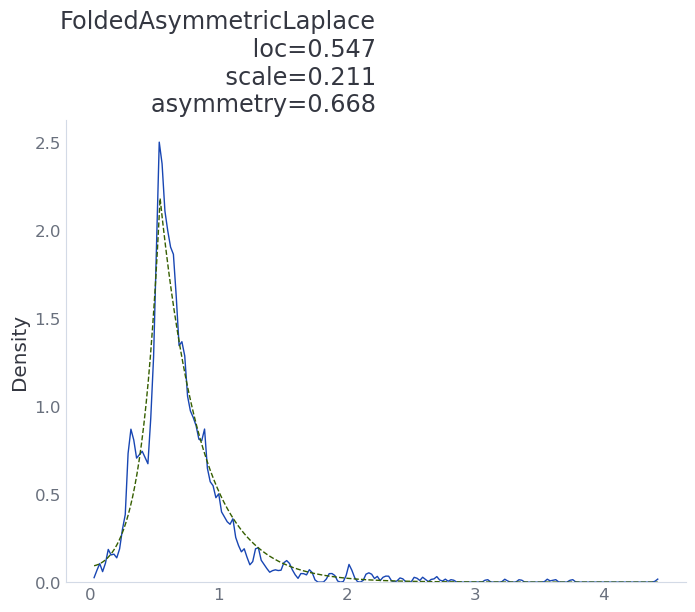

In [11]:
res_df = caveman_fit(df.query('needs_tight_radii and volume_ratio <= 10')['volume_ratio'] - 0.6).round(3)
res_df.head()

## Lattice Parameters

Generating lattices is complicated. They can have up to six degrees of freedom instead of just one. We generate the volume first, so there are less than that in practice, but it's still a difficult problem. The real solution here probably involves a neural flow that incorporates other information. The reason why this is significantly more challenging, aside from the dimensionality, is that lattice shapes are much spikier as a distribution. I think this is due to simple geometry: there are only so many configurations of different atoms with a couple bonds each, and unit cells tend to have specific ratios that are determined by the shape of a hexagon or a pentagon or some other motif.

I will attempt to follow the ITA conventions as much as possible, except for using primitive cells. We don't want to have symmetric copies that require extra computational power to generate.

### Tetragonal

For lattices with $\alpha = \beta = \gamma = 90^{\circ}$ with 2 distinct values among $a, b, c$, we follow ITA and set $a = b$. 

For all of these lattice types, we're intentionally loose in classifying them: if a structure is very close to being more symmetric, it'll be much easier to generate the symmetric version and relax it than to generate the less symmetric version.

In [35]:
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from tqdm import tqdm

lat_data = []

sgas = []

for ind in tqdm(df.index):
    sga = SpacegroupAnalyzer(df.loc[ind, 'struct'], symprec=0.01)
    sgas.append(sga)
    struct = sga.get_conventional_standard_structure()
    lat = struct.lattice.scale(1)
    angles = np.array(lat.angles)
    abc = np.array(lat.abc)
    if np.allclose(angles, 90, atol=0.2):
        n_uniq = 3 - sum(np.diff(np.sort(abc)) <= 0.01)
        if n_uniq == 1:
            lat_type = 'cubic'
            a = b = c = np.median(abc)
            A = B = Y = 90
        elif n_uniq == 2:
            lat_type = 'tetragonal'
            is_c = np.arange(3) == np.argmax(np.abs(abc - np.median(abc)))
            c = abc[is_c][0]
            a, b = abc[~is_c]
            A = B = Y = 90
        else:
            lat_type = 'orthorhombic'
            a, b, c = abc
            A, B, Y = angles
    elif np.allclose(sorted(angles), (90, 90, 120), atol=0.2):
        lat_type = 'hexagonal'
        is_c = np.arange(3) == np.argmin(np.abs(angles - 120))
        c = abc[is_c][0]
        a, b = abc[~is_c]
        A, B, Y = 90, 90, 120
    elif np.std(angles) <= 1e-2 and np.std(abc) <= 1e-2:
        lat_type = 'rhombohedral'
        A = B = Y = np.median(angles)
        a = b = c = np.median(abc)
    elif sum(np.isclose(angles, 90, atol=0.1)) == 2:
        lat_type = 'monoclinic'
        is_b = np.arange(3) == np.argmax(np.abs(angles - 90))
        b = abc[is_b][0]
        a, c = abc[~is_b]
        B = angles[is_b][0]
        A, Y = angles[~is_b]
    else:
        lat_type = 'triclinic'
        a, b, c = abc
        A, B, Y = angles

    lat_data.append([lat_type, a, b, c, A, B, Y])

lat_cols = ['lat_type', 'a', 'b', 'c', 'A', 'B', 'Y']
df.loc[:, lat_cols] = pd.DataFrame(lat_data, index=df.index, columns=lat_cols)
df[lat_cols[1:]] = df[lat_cols[1:]].astype(float)

  4%|▎         | 960/27136 [00:07<03:54, 111.78it/s]spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 0 tolerance = 1.000000e-02 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 1 tolerance = 9.500000e-03 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 2 tolerance = 9.025000e-03 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 3 tolerance = 8.573750e-03 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 4 tolerance = 8.145062e-03 failed(line 800, /project/src/spacegroup.c).
spglib: No point group was found (line 405, /project/src/pointgroup.c).
spglib: Attempt 5 tolerance = 7.737809e-03 failed(line 800, /project/src/spa

In [49]:
pd.crosstab(df['lattice_type'], df['lat_type'])

lat_type,cubic,hexagonal,monoclinic,orthorhombic,tetragonal,triclinic
lattice_type,,,,,,
cubic,6168,8,10,0,13,3
hexagonal,2,5804,42,45,0,28
monoclinic,13,31,3723,122,60,108
orthorhombic,21,3,41,4359,831,17
tetragonal,79,0,12,5,4435,7
triclinic,1,2,36,12,10,1085


In [50]:
df.query('lattice_type == "orthorhombic" and lat_type == "tetragonal"')[['material_id', 'pretty_formula', 'lattice_type', 'sg_symbol', *lat_cols]]

,material_id,pretty_formula,lattice_type,sg_symbol,lat_type,a,b,c,A,B,Y
106,mp-21510,K2NaInAs2,orthorhombic,Ibam,tetragonal,0.759140,0.764087,1.723994,90.0,90.0,90.0
152,mp-753348,Fe(CoO2)2,orthorhombic,Imma,tetragonal,0.896805,0.899092,1.240218,90.0,90.0,90.0
180,mp-1189057,LuGePd2,orthorhombic,Pnma,tetragonal,1.088092,1.089268,0.843723,90.0,90.0,90.0
243,mp-1220006,Pr(InCu)6,orthorhombic,Immm,tetragonal,1.178955,1.188213,0.713853,90.0,90.0,90.0
248,mp-1189549,LiH2N,orthorhombic,Fddd,tetragonal,0.858840,0.865992,1.344542,90.0,90.0,90.0
...,...,...,...,...,...,...,...,...,...,...,...
26959,mp-1207677,U3(CuSi)4,orthorhombic,Immm,tetragonal,0.547581,0.555431,3.287921,90.0,90.0,90.0
26962,mp-27488,Ta3N5,orthorhombic,Cmcm,tetragonal,1.381660,1.385546,0.522370,90.0,90.0,90.0
27013,mp-1102621,ErCoSi,orthorhombic,Pnma,tetragonal,1.179501,1.180338,0.718283,90.0,90.0,90.0
27060,mp-1218412,Sr4TaFeO8,orthorhombic,Cmmm,tetragonal,0.761802,0.761437,1.723947,90.0,90.0,90.0


The disagreements come from approximate equalities that are treated differently by my code and `spglib`. We're going to be safe and just remove those from consideration, because it's unclear what type of lattice best fits them. 

In [57]:
df['consistent_lattice'] = df.eval('lat_type == lattice_type')

### Cubic

This one's easy: there are no degrees of freedom after volume, and so we just take $a = b = c = \sqrt[3]{v}$.

### Triclinic

This one's a challenge.

In [58]:
df.query('consistent_lattice and lat_type == "triclinic"').b.astype(float)

10       1.128809
56       0.900952
92       1.068958
93       1.102185
145      1.022324
           ...   
26894    1.163579
26907    1.118626
26988    1.085553
27038    1.090365
27079    0.895284
Name: b, Length: 1085, dtype: float64

<class 'pyro.distributions.asymmetriclaplace.AsymmetricLaplace'>
<class 'pyro.distributions.logistic.SkewLogistic'>
<class 'pyro.distributions.asymmetriclaplace.AsymmetricLaplace'>
<class 'pyro.distributions.torch.Weibull'>
<class 'pyro.distributions.torch.Weibull'>
<class 'pyro.distributions.torch.Weibull'>


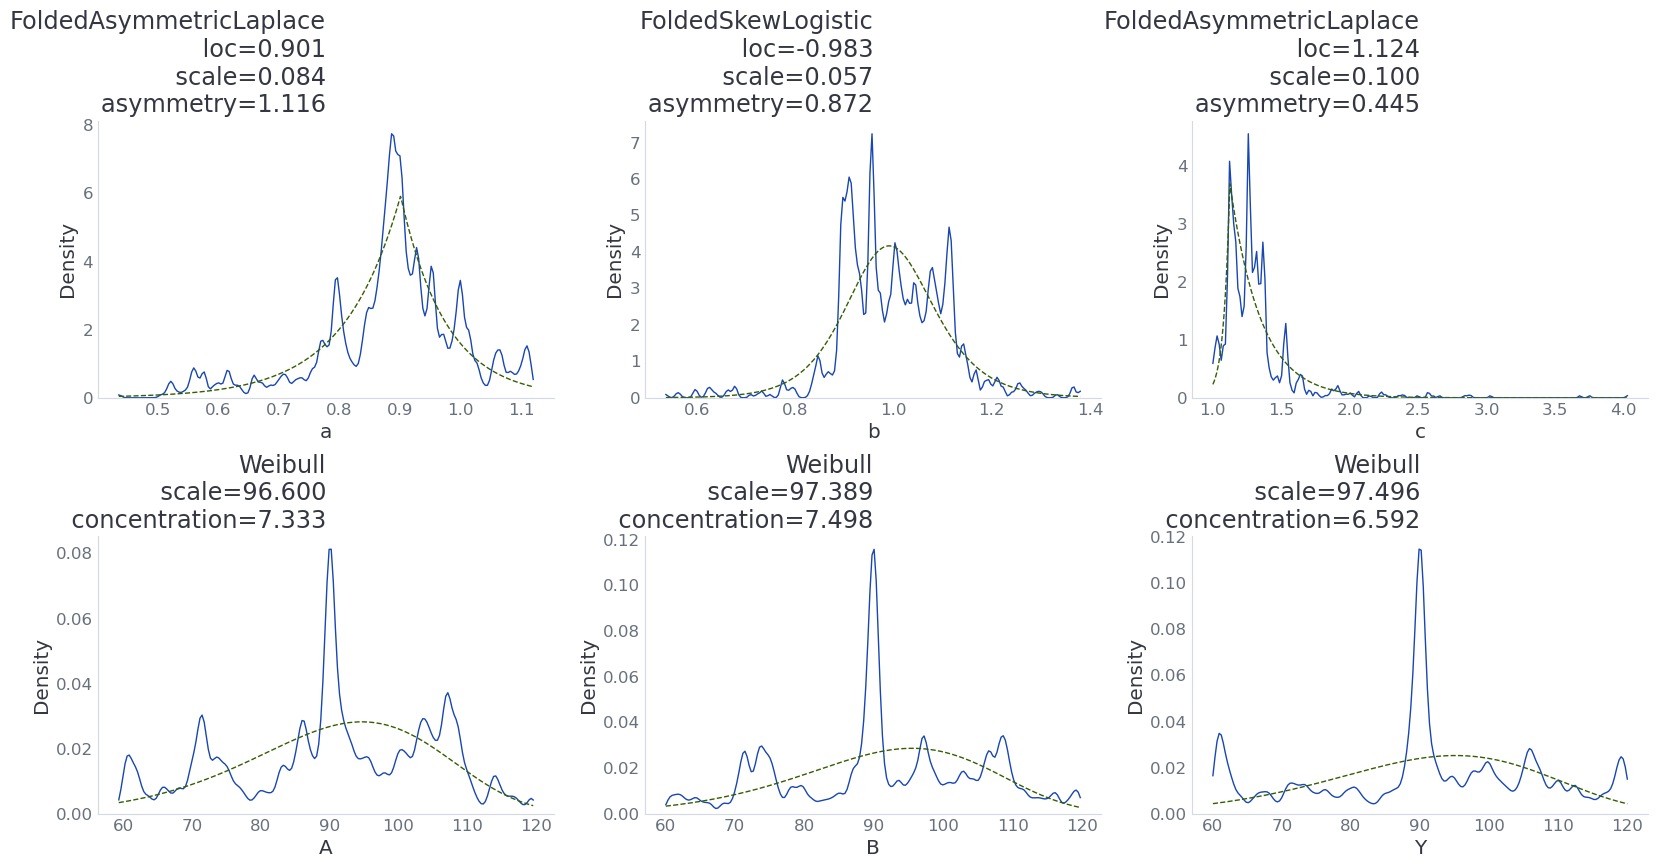

In [59]:
fig, axs = plt.subplots(2, 3, figsize=(20, 9), gridspec_kw=dict(hspace=0.5))
for ax, let in zip(axs.flatten(), 'abcABY'):
    plt.sca(ax)
    ax.set_xlabel(let)
    caveman_fit(df.query('consistent_lattice and lat_type == "triclinic"')[let])

### Hexagonal

We analyze the conventional hexagonal lattice here. There's a bijection between these parameters and the rhombohedral parameters, and the hexagonal ones are more common.

We can see, like before, that there are significant spikes. We don't try to model these right now, but it seems that they mostly correspond to specific geometric motifs found in different space groups. 

As far as free parameters, there's only one: we have $a = b$ and $(\alpha, \beta, \gamma) = (90, 90, 120)$, so the only thing to determine is the relative magnitude of $a$ and $c$. We parameterize that as $a / c$.

<class 'pyro.distributions.asymmetriclaplace.SoftAsymmetricLaplace'>


,family,kl,loc,scale,asymmetry,softness,concentration,rate,df,df1,df2,params
0,FoldedSoftAsymmetricLaplace,0.025975,7.831033e-02,0.081358,0.115504,0.122011,NaN,NaN,NaN,NaN,NaN,"{'loc': 0.07831033190383706, 'scale': 0.081357..."
1,Gamma,0.043634,NaN,NaN,NaN,NaN,1.590333,2.054853,NaN,NaN,NaN,"{'concentration': 1.5903331434595995, 'rate': ..."
2,Weibull,0.047444,NaN,0.844024,NaN,NaN,1.310194,NaN,NaN,NaN,NaN,"{'scale': 0.8440241544690398, 'concentration':..."
3,FoldedNormal,0.062730,-4.792342e-10,0.979346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'loc': -4.792341960675121e-10, 'scale': 0.979..."
4,FoldedNanMaskedNormal,0.062730,-4.792342e-10,0.979346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'loc': -4.792341960675121e-10, 'scale': 0.979..."


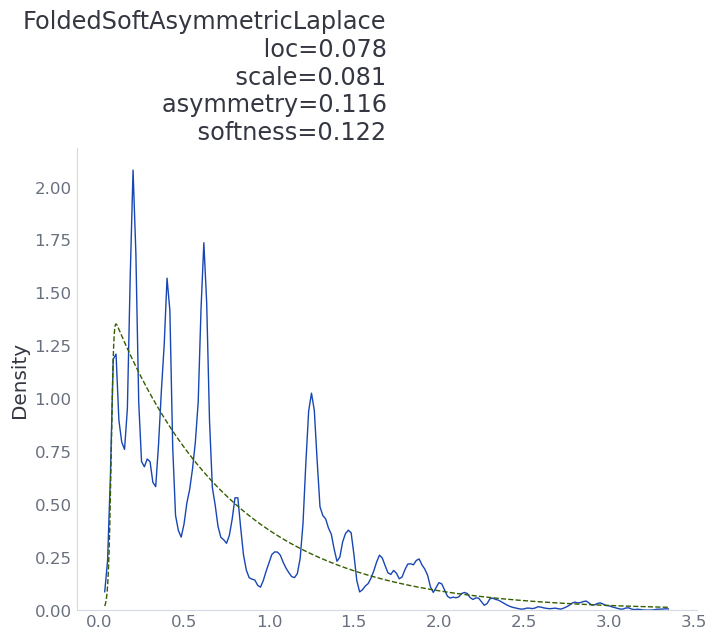

In [85]:
res_df = caveman_fit(df.query('consistent_lattice and lattice_type == "hexagonal"').eval('a / c'))
res_df.head()

<class 'pyro.distributions.torch.Gamma'>


,family,kl,concentration,rate,loc,scale,asymmetry,df,softness,df1,df2,params
0,Gamma,0.118310,82.471159,0.751653,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'concentration': 82.47115869135794, 'rate': 0..."
1,LogNormal,0.118676,NaN,NaN,4.691855e+00,0.110534,NaN,NaN,NaN,NaN,NaN,"{'loc': 4.691855252230727, 'scale': 0.11053409..."
2,InverseGamma,0.120114,82.018219,8890.135406,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'concentration': 82.01821888357763, 'rate': 8..."
3,FoldedSkewLogistic,0.142351,NaN,NaN,5.372154e-01,10.868363,13348.324250,NaN,NaN,NaN,NaN,"{'loc': 0.5372154035970469, 'scale': 10.868363..."
4,Weibull,0.153028,9.885205,NaN,NaN,115.202732,NaN,NaN,NaN,NaN,NaN,"{'scale': 115.20273156079828, 'concentration':..."
5,Chi2,0.154191,NaN,NaN,NaN,NaN,NaN,110.054672,NaN,NaN,NaN,{'df': 110.05467214193246}
6,FoldedNanMaskedNormal,1.640124,NaN,NaN,-5.637600e-07,109.905178,NaN,NaN,NaN,NaN,NaN,"{'loc': -5.637599686425557e-07, 'scale': 109.9..."
7,FoldedNormal,1.640124,NaN,NaN,-5.637600e-07,109.905178,NaN,NaN,NaN,NaN,NaN,"{'loc': -5.637599686425557e-07, 'scale': 109.9..."
8,HalfNormal,1.640124,NaN,NaN,NaN,109.905175,NaN,NaN,NaN,NaN,NaN,{'scale': 109.90517500580617}
9,FoldedStudentT,1.647043,NaN,NaN,-6.371865e-08,110.098030,NaN,70.227288,NaN,NaN,NaN,"{'df': 70.22728769724539, 'loc': -6.3718649248..."


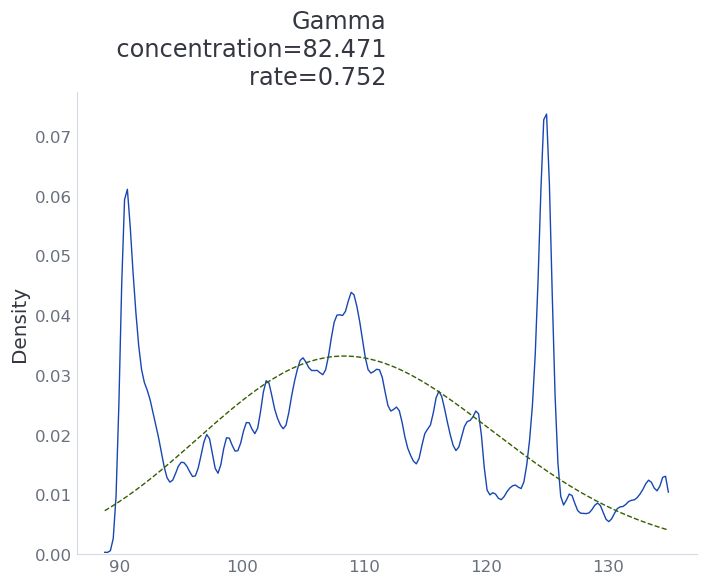

In [86]:
caveman_fit(df.query('consistent_lattice and lattice_type == "monoclinic"').B)